In [1]:
import os
import sys
import math
import time
import copy
import random
import tempfile
from functools import reduce
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.special import softmax
import scipy.io

import torch
from torch import nn
import torch.nn.functional as F

from utils.visualization import plot_prob_simplex, plot_cal_regions_ternary
from ternary.helpers import project_sequence
from flows.flows import Flow, AffineConstantLayer, NvpCouplingLayer, PlanarLayer

In [2]:
%matplotlib inline
plt.ioff()

In [3]:
log2PI = np.log(2*math.pi)
dev = torch.device('cpu')

In [4]:
epochs = 5000

In [5]:
def save_model(name, model_dict, path='.'):
    full_path = os.path.join(path, name)
    
    if not os.path.exists(full_path):
        os.makedirs(full_path)
    
    model = model_dict['model']
    
    # Save pytorch model
    torch.save(model.state_dict(), os.path.join(full_path, 'model.pth'))

In [6]:
def train_flow(train, test):
    dim = train.shape[1]
    
    # Convertir a pytorch
    X = torch.as_tensor(train, dtype=torch.float).to(dev)
    Test = torch.as_tensor(test, dtype=torch.float).to(dev)

    # Instantiate model
    model = Flow([NvpCouplingLayer(dim, hidden_size=[10, 10], random_flip=True) for _ in range(10)]).to(dev)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.1)

    loss = []
    logpz = []
    logdet = []

    # Train loop
    t0 = time.time()
    model.train()
    for e in range(epochs):

        cum_loss = torch.zeros(1, device=dev)
        cum_logdet = torch.zeros(1, device=dev)
        cum_logprior = torch.zeros(1, device=dev)

        preds, _logdet = model(X)

        _logdet = torch.mean(_logdet)
        _logpz = torch.mean(-0.5 * (log2PI*dim + torch.sum(torch.pow(preds[-1], 2), dim=1)))
        _loss = -_logpz - _logdet*(e>10)

        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        loss.append(_loss.item())
        logpz.append(_logpz.item())
        logdet.append(_logdet.item())
        
        if e%10 == 9:
            print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}, log(det): {:.3f}'.format(e, time.time()-t0, loss[-1], logpz[-1], logdet[-1]), end="\r")
         
    model.eval()
    g_train, _ = model(X)
    g_train = g_train[-1].detach().cpu().numpy()
    
    g_test, _ = model(Test)
    g_test = g_test[-1].detach().cpu().numpy()
    
    model_dict = {
        'model': model,
        'logpz': np.array(logpz),
        'logdet': np.array(logdet),
    }
        
    return model_dict, g_train, g_test

In [7]:
data_path = os.path.join('..', 'enusa')

mat_train = scipy.io.loadmat(os.path.join(data_path, 'datosentrenamiento_NF_gauss.mat'))
mat_train = mat_train['datosentrenamiento_NF_gauss']
mat_train_g = copy.deepcopy(mat_train)
mat_test = scipy.io.loadmat(os.path.join(data_path, 'datostest_NF_gauss.mat'))
mat_test = mat_test['datostest_NF_gauss']
mat_test_g = copy.deepcopy(mat_test)

Central: 0
Ciclo: 0


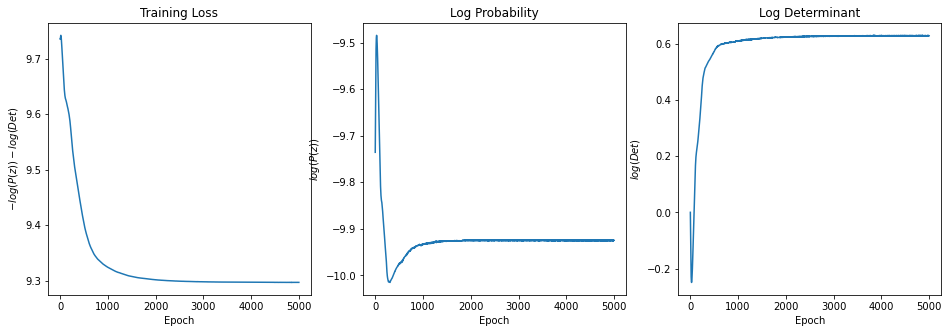

Ciclo: 1


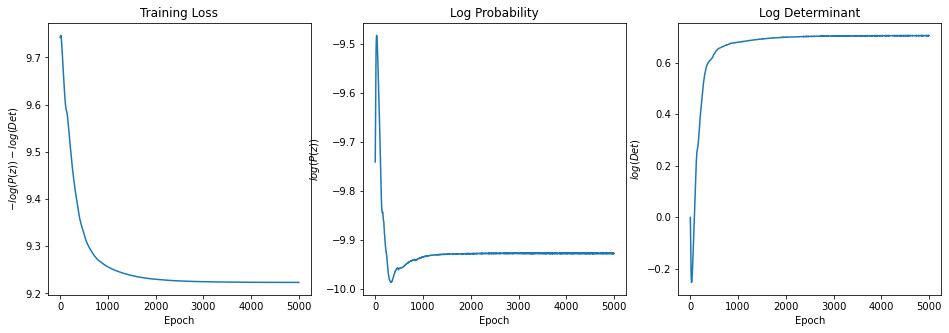

Ciclo: 2


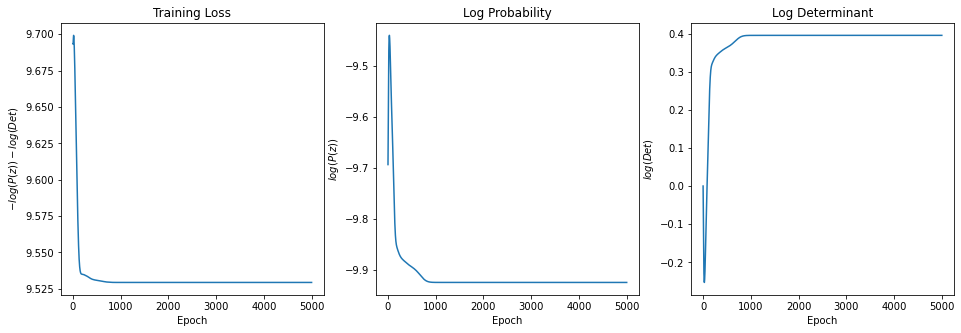

Ciclo: 3


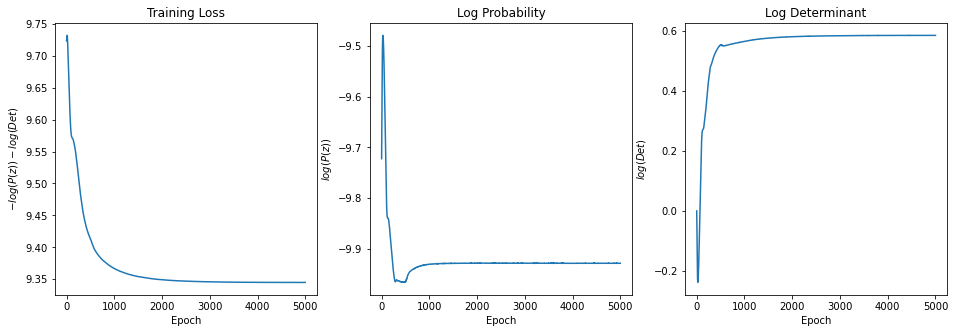

Ciclo: 4


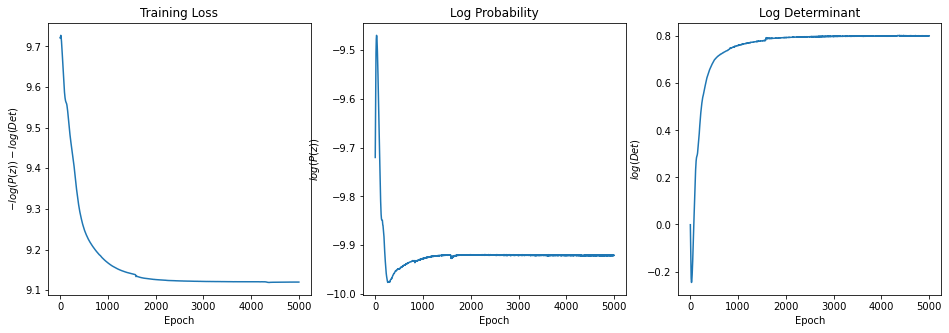

Ciclo: 5
La central 0 no tiene tantos ciclos majo
Central: 1
Ciclo: 0


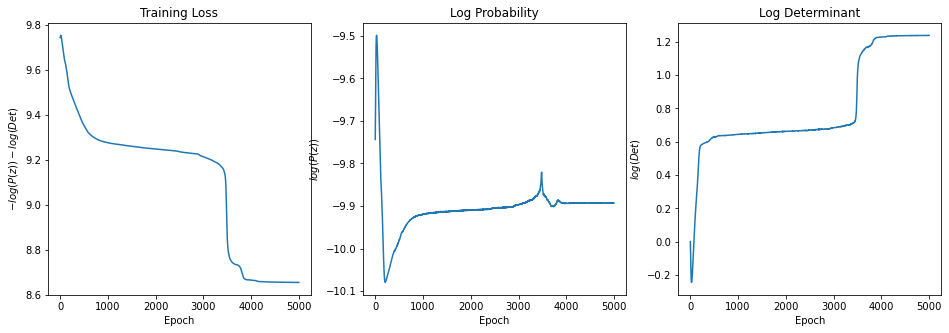

Ciclo: 1


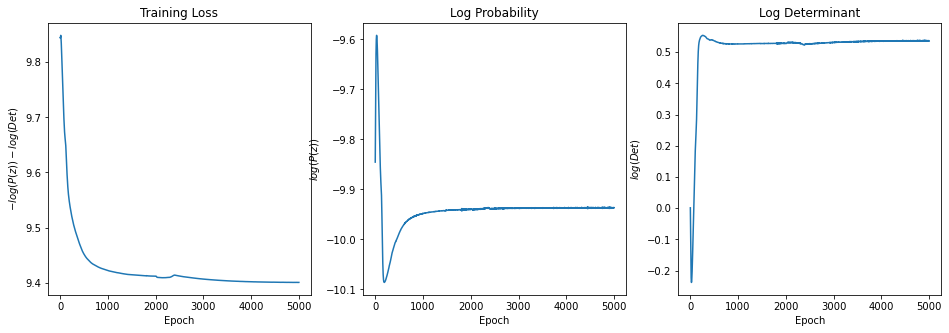

Ciclo: 2


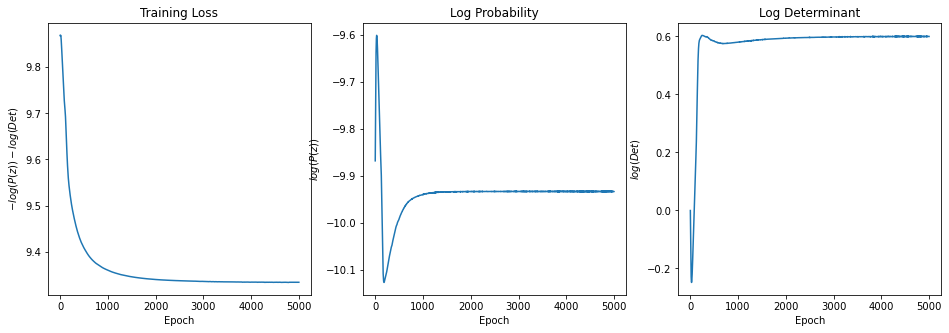

Ciclo: 3


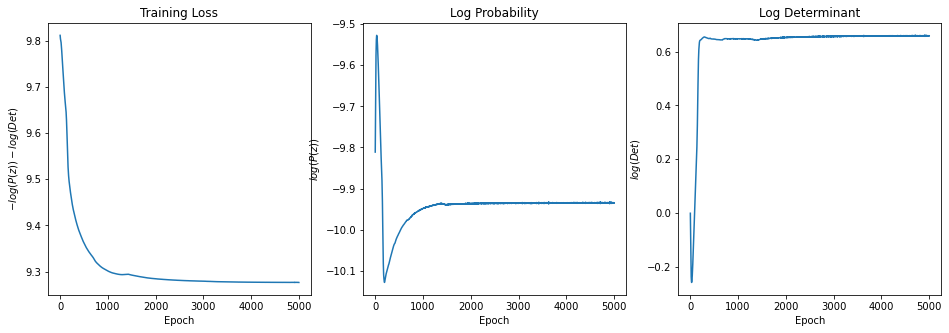

Ciclo: 4


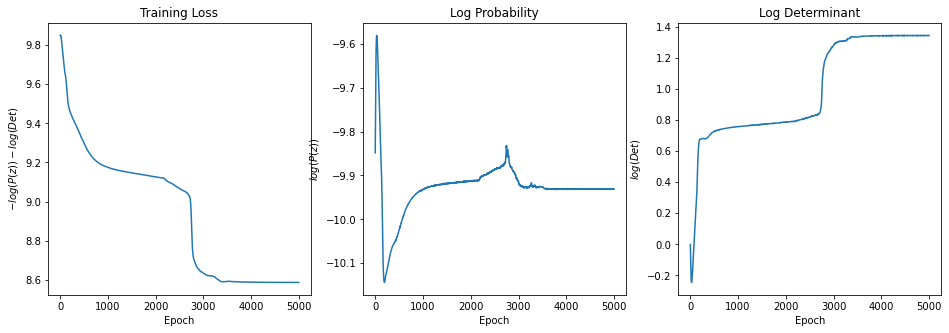

Ciclo: 5


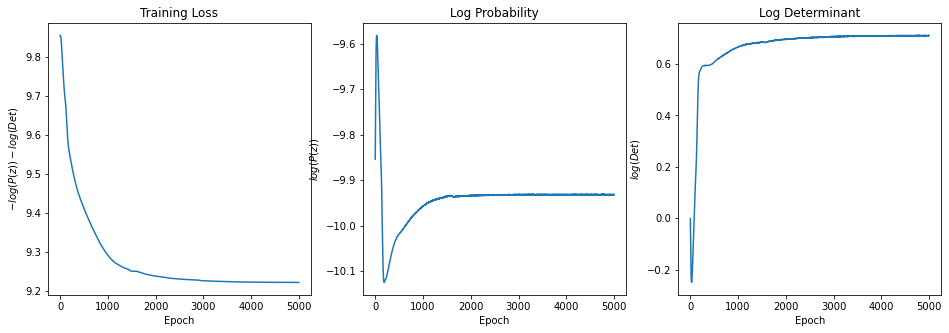

Central: 2
Ciclo: 0


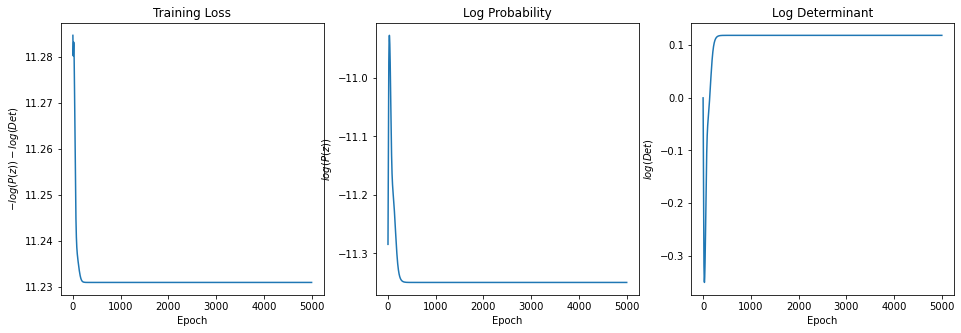

Ciclo: 1


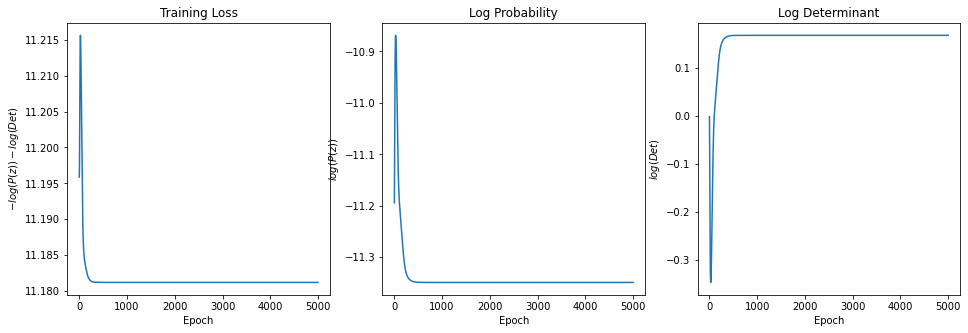

Ciclo: 2


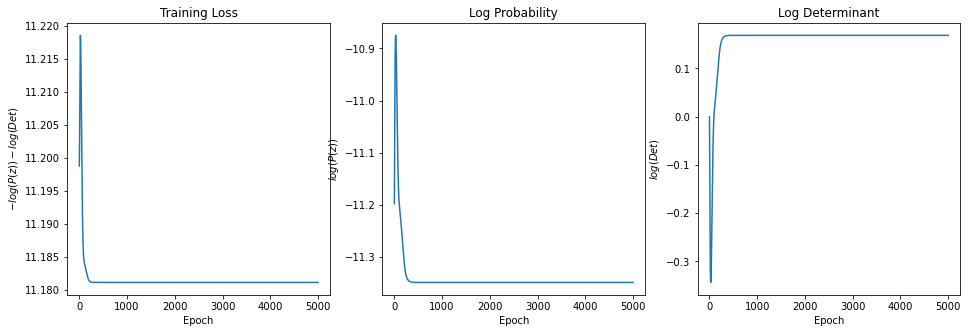

Ciclo: 3
La central 2 no tiene tantos ciclos majo
Central: 3
Ciclo: 0


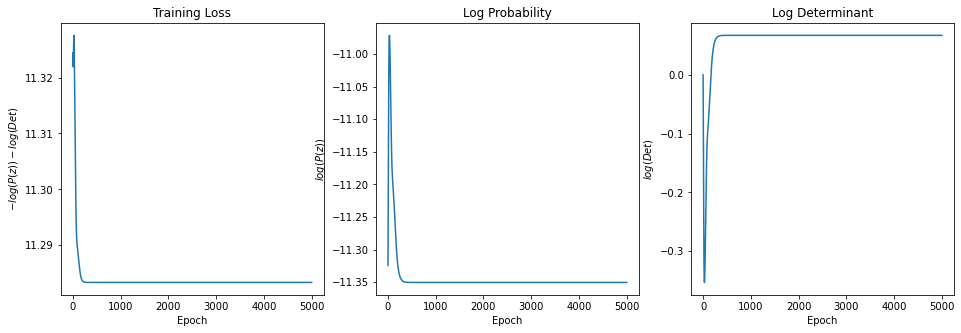

Ciclo: 1


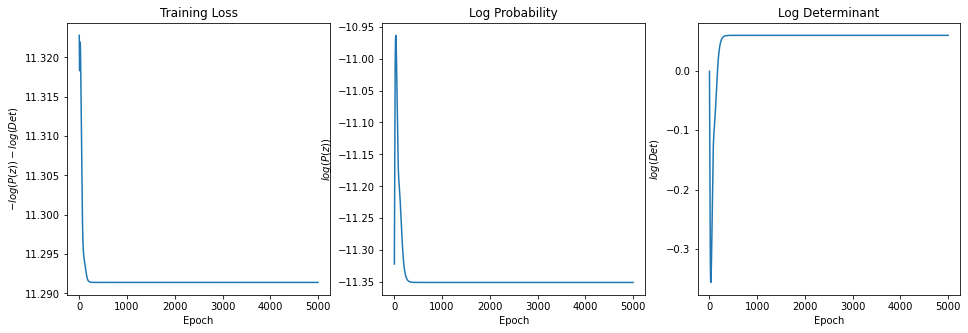

Ciclo: 2


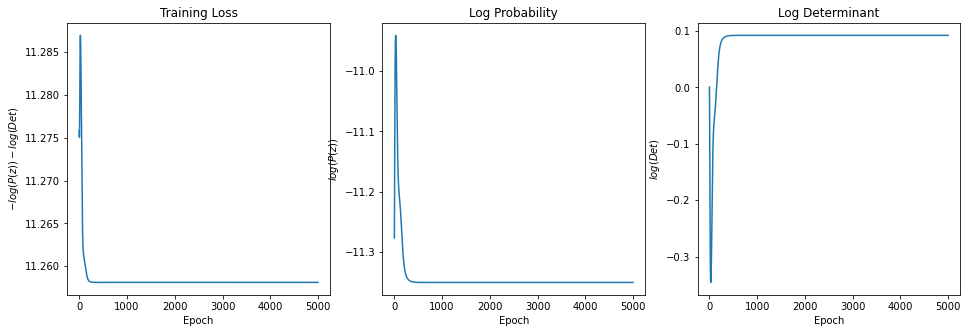

Ciclo: 3


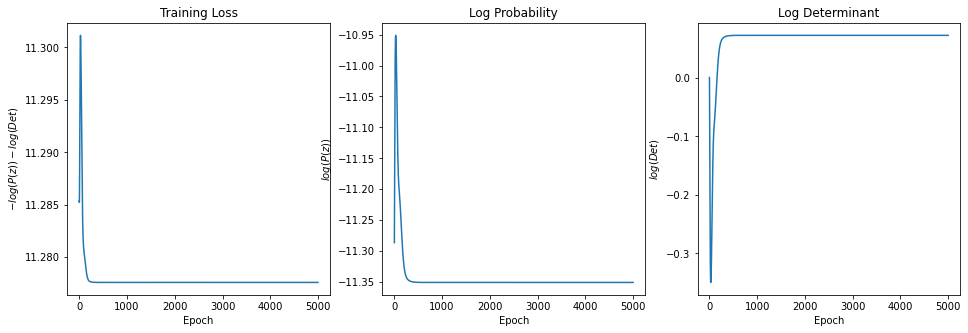

Ciclo: 4
La central 3 no tiene tantos ciclos majo
Central: 4
Ciclo: 0


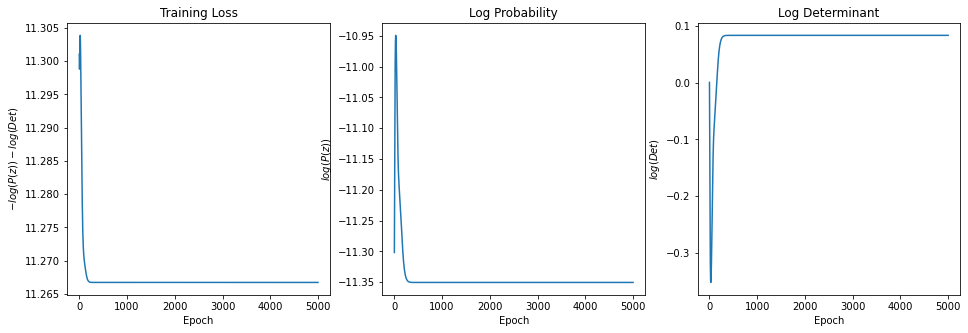

Ciclo: 1


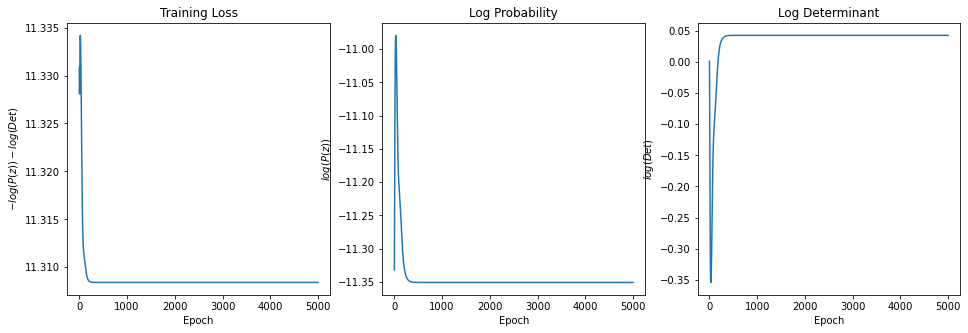

Ciclo: 2


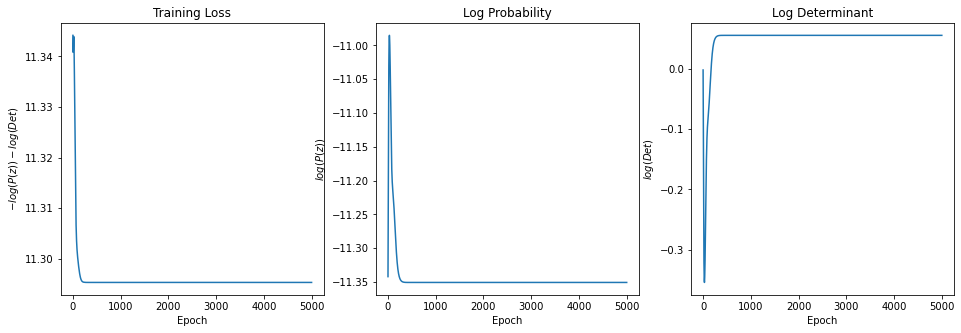

Ciclo: 3


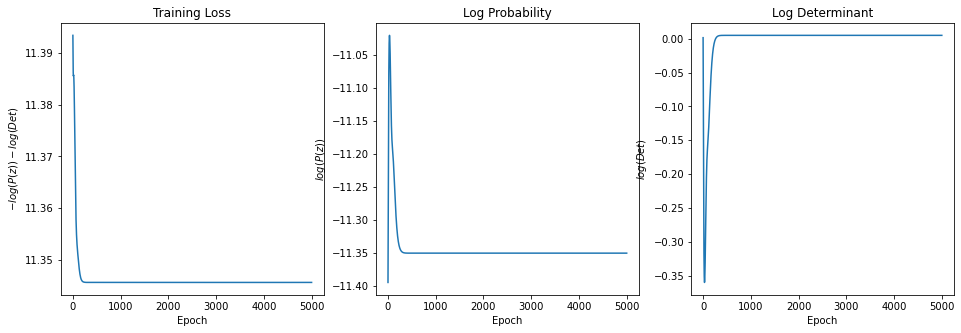

Ciclo: 4
La central 4 no tiene tantos ciclos majo


In [8]:
for central in range(mat_train.shape[0]):
    print('Central: {:d}'.format(central))
    for ciclo in range(mat_train.shape[1]):
        print('Ciclo: {:d}'.format(ciclo))
        if mat_train[central, ciclo].size <= 0:
            print('La central {:d} no tiene tantos ciclos majo'.format(central))
            break
            
        mat_train_g[central, ciclo][0, 0] = np.nan
        while(np.isnan(np.sum(mat_train_g[central, ciclo]))or np.isnan(np.sum(mat_test_g[central, ciclo]))):
            train = mat_train[central, ciclo]
            test = mat_test[central, ciclo]

            model_dict, g_train, g_test = train_flow(train, test)

            mat_train_g[central, ciclo] = g_train
            mat_test_g[central, ciclo] = g_test

            # Save model
            name = os.path.join(data_path, 'central{:d}ciclo{:d}_gauss'.format(central, ciclo))

            save_model(name, model_dict, path=name)
            # Plot training NLL
            fig, ax = plt.subplots(1, 3, figsize=(16, 5))

            ax[0].plot(-(model_dict['logpz'] + model_dict['logdet']))
            ax[1].plot(model_dict['logpz'])
            ax[2].plot(model_dict['logdet'])


            ax[0].set_title('Training Loss')
            ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
            ax[0].set_xlabel('Epoch')

            ax[1].set_title('Log Probability')
            ax[1].set_ylabel(r'$log(P(z))$')
            ax[1].set_xlabel('Epoch')

            ax[2].set_title('Log Determinant')
            ax[2].set_ylabel(r'$log(Det)$')
            ax[2].set_xlabel('Epoch')

            plt.show()
        
        
        

In [9]:
model_dict['model'].layers[0].perm

Parameter containing:
tensor([[3, 2, 0, 5, 4, 7, 6, 1]])

In [13]:
plt.scatter(mat_test_g[0, 0][:, 3], mat_test_g[0, 0][:, 7])
plt.show()

IndexError: index 7 is out of bounds for axis 1 with size 7

scipy.io.savemat(os.path.join(data_path, 'datosentrenamiento_NF_gauss_Z.mat'), {'datosentrenamiento_NF_gauss_Z':mat_train_g})
scipy.io.savemat(os.path.join(data_path, 'datostest_NF_gauss_Z.mat'), {'datostest_NF_gauss_Z':mat_test_g})


In [50]:
mat_media = scipy.io.loadmat(os.path.join(data_path, 'Inferencia_media_datos_gauss_NF.mat'))
mat_media = mat_media['Inferencia_media_datos_gauss_NF']
mat_media_g = copy.deepcopy(mat_media)

"""
mat_sup = scipy.io.loadmat(os.path.join(data_path, 'Inferencia_margen_superior_gauss_NF.mat'))
mat_sup = mat_sup['Inferencia_margen_superior_gauss_NF']
mat_sup_g = copy.deepcopy(mat_sup)

mat_inf = scipy.io.loadmat(os.path.join(data_path, 'Inferencia_margen_inferior_gauss_NF.mat'))
mat_inf = mat_inf['Inferencia_margen_inferior_gauss_NF']
mat_inf_g = copy.deepcopy(mat_inf)
"""

"\nmat_sup = scipy.io.loadmat(os.path.join(data_path, 'Inferencia_margen_superior_gauss_NF.mat'))\nmat_sup = mat_sup['Inferencia_margen_superior_gauss_NF']\nmat_sup_g = copy.deepcopy(mat_sup)\n\nmat_inf = scipy.io.loadmat(os.path.join(data_path, 'Inferencia_margen_inferior_gauss_NF.mat'))\nmat_inf = mat_inf['Inferencia_margen_inferior_gauss_NF']\nmat_inf_g = copy.deepcopy(mat_inf)\n"

In [51]:
for central in range(mat_train.shape[0]):
    print('Central: {:d}'.format(central))
    for ciclo in range(mat_train.shape[1]):
        print('Ciclo: {:d}'.format(ciclo))
        if mat_train[central, ciclo].size <= 0:
            print('La central {:d} no tiene tantos ciclos majo'.format(central))
            break
            
        dim = mat_media_g[central, ciclo].shape[1]
        
        # Load model
        name = os.path.join(data_path, 'enusa/central{:d}ciclo{:d}_gauss'.format(central, ciclo))
        model = Flow([NvpCouplingLayer(dim, hidden_size=[10, 10], random_flip=True) for _ in range(10)])
        model.load_state_dict(torch.load(os.path.join(name, 'model.pth')))
        model.eval()
        
        mat_media_g[central, ciclo] = model.backward(torch.as_tensor(mat_media[central, ciclo], dtype=torch.float))[0][-1].detach().numpy()

Central: 0
Ciclo: 0
Ciclo: 1
Ciclo: 2
Ciclo: 3
Ciclo: 4
Ciclo: 5
La central 0 no tiene tantos ciclos majo
Central: 1
Ciclo: 0
Ciclo: 1
Ciclo: 2
Ciclo: 3
Ciclo: 4
Ciclo: 5
Central: 2
Ciclo: 0
Ciclo: 1
Ciclo: 2
Ciclo: 3
La central 2 no tiene tantos ciclos majo
Central: 3
Ciclo: 0
Ciclo: 1
Ciclo: 2
Ciclo: 3
Ciclo: 4
La central 3 no tiene tantos ciclos majo
Central: 4
Ciclo: 0
Ciclo: 1
Ciclo: 2
Ciclo: 3
Ciclo: 4
La central 4 no tiene tantos ciclos majo


In [55]:
scipy.io.savemat(os.path.join(data_path, 'Inferencia_media_datos_degauss_NF.mat'), {'Inferencia_media_datos_degauss_NF':mat_media_g})

In [56]:
mat_media_g

array([[array([[-8.16705227e-01, -1.45260620e+00,  5.19870460e-01,
        -5.44849038e-01,  9.67035294e-01,  1.80878425e+00,
         1.51079154e+00],
       [-1.27405703e+00, -1.73895851e-01,  2.85324305e-01,
        -4.36186194e-01,  4.65042233e-01,  9.47051942e-01,
         8.28475118e-01],
       [-9.13017094e-01, -1.35341990e+00,  2.85640150e-01,
        -2.54303575e-01,  1.39184937e-01,  5.77093124e-01,
         5.00815570e-01],
       [-8.16705227e-01,  9.55854058e-01, -3.88482898e-01,
        -2.94332564e-01,  3.47456276e-01,  4.87998933e-01,
         4.58840758e-01],
       [-8.16705227e-01, -1.31950390e+00,  4.83603179e-01,
        -1.64323911e-01,  5.41308196e-03,  4.02624309e-01,
         3.33897978e-01],
       [-5.77092946e-01,  9.30740118e-01,  4.77036357e-01,
        -1.66802123e-01,  1.60387740e-01,  3.31736714e-01,
         2.47276917e-01],
       [-7.13120878e-01, -1.67060733e-01,  4.76158917e-01,
        -1.40855774e-01,  3.49279009e-02,  2.96930164e-01,
         2

In [40]:
dim = mat_media[0, 0].shape[1]
name = os.path.join(data_path, 'enusa/central{:d}ciclo{:d}_gauss'.format(0, 0))
model = Flow([NvpCouplingLayer(dim, hidden_size=[10, 10], random_flip=True) for _ in range(10)])
model.load_state_dict(torch.load(os.path.join(name, 'model.pth')))
model.eval()

Flow(
  (layers): ModuleList(
    (0): NvpCouplingLayer(
      (s): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=7, out_features=10, bias=True)
          (1): Linear(in_features=10, out_features=10, bias=True)
          (2): Linear(in_features=10, out_features=7, bias=True)
        )
      )
      (t): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=7, out_features=10, bias=True)
          (1): Linear(in_features=10, out_features=10, bias=True)
          (2): Linear(in_features=10, out_features=7, bias=True)
        )
      )
    )
    (1): NvpCouplingLayer(
      (s): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=7, out_features=10, bias=True)
          (1): Linear(in_features=10, out_features=10, bias=True)
          (2): Linear(in_features=10, out_features=7, bias=True)
        )
      )
      (t): MLP(
        (layers): ModuleList(
          (0): Linear(in_features=7, out_features=10, bias=True)
          (1): Line

In [46]:
a = model.backward(torch.as_tensor(mat_media[0, 0]))[0]

In [48]:
a[-1].shape

torch.Size([57, 7])